In [2]:
from tomo2mesh.structures.voids import VoidLayers
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import os
import sys
sys.path.append('/data01/Tomo2Mesh/scratchpad/polymer_am_eaton/code/')
from rw_utils import read_raw_data_1X, save_path
from void_mapping import void_map_gpu
from params import pixel_size_1X as pixel_size

plots_dir = '/home/yash/eaton_plots/'
if not os.path.exists(plots_dir):
    os.makedirs(plots_dir)
import matplotlib as mpl
mpl.use('Agg')


In [2]:
sample_tag = 1
fpath = f'/data01/Eaton_Polymer_AM/voids_data/sample{sample_tag}_all_layers'
radius = 50

In [3]:
voids_all = VoidLayers().import_from_disk(fpath)
# surf = voids_all.export_void_mesh_with_texture("max_feret")
# surf.write_ply(f'/data01/Eaton_Polymer_AM/voids_data/sample{sample_tag}_feretdm_all_layers')

In [4]:
voids_all.keys()
voids_all.calc_max_feret_dm()
voids_all.calc_number_density(radius)
voids_all.write_to_disk(fpath)

	TIME: calculate max feret diameter 53.84 secs
	TIME: calculate number density 140.13 secs


In [49]:
feret_dm = voids_all["max_feret"]["dia"]
eq_sph_dm = voids_all["max_feret"]["eq_sph"]
norm_dm = voids_all["max_feret"]["norm_dia"]
theta = voids_all["max_feret"]["theta"]
phi = voids_all["max_feret"]["phi"]

eq_sph_vol = (4/3)*np.pi*radius**3
x_voids = voids_all["x_voids"]
z_cent = voids_all["cents"][:,0]
y_cent = voids_all["cents"][:,1]
x_cent = voids_all["cents"][:,2]
num_den = np.array(voids_all["number_density"])/eq_sph_vol

## Number density with Z

In [38]:
unique_z_val = np.unique(z_cent)

z_cent_mean = []
num_den_mean = []
z_cent_std = []
num_den_std = []
loc = []
count1=0
for i in range(0,len(unique_z_val)):
    count1+=1
    loc += np.where(z_cent == unique_z_val[i])[0].tolist()
    if count1==4:
        temp1 = []
        temp2 = []
        for j in range(len(loc)):
            temp1.append(num_den[loc[j]])
            temp2.append(z_cent[loc[j]])
        num_den_mean.append(np.mean(temp1))
        z_cent_mean.append(np.mean(temp2))
        num_den_std.append(np.std(temp1)/len(temp1)**0.5)
        z_cent_std.append(np.std(temp2)/len(temp2)**0.5)
        count1 = 0
        loc = []

z_cent_mean = np.array(z_cent_mean)*3.13*4*10**(-3)
z_cent_std = np.array(z_cent_std)*3.13*4*10**(-3)
num_den_mean = np.asarray(num_den_mean)*1.0e4
num_den_std = np.asarray(num_den_std)*1.0e4

(3.0, 5.0)

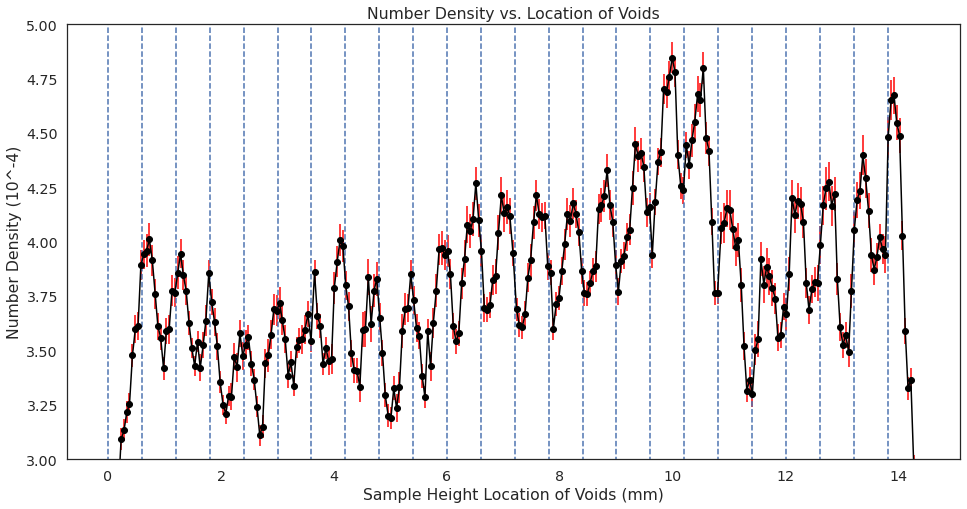

In [39]:
sns.set(font_scale=1.3)
sns.set_style(style = "white")
fig, ax = plt.subplots(1,1, figsize = (16,8))
ax.errorbar(z_cent_mean, num_den_mean, xerr=z_cent_std, yerr=num_den_std, fmt='-o', color = 'black', ecolor = 'red')
ax.set_title("Number Density vs. Location of Voids")
ax.set_ylabel("Number Density (10^-4)")
ax.set_xlabel("Sample Height Location of Voids (mm)")
#ax.set(xlim=(20, 1130))

# lines
lines_600um = np.arange(0,max(z_cent_mean),0.6)
ax.vlines(lines_600um, 0, 6,linestyles='--')
ax.set_ylim([3,5])

## Number density with Y

In [40]:
unique_y_val = np.unique(y_cent)

y_cent_mean = []
num_den_mean = []
loc = []
y_cent_std = []
num_den_std = []
count1=0
for i in range(0,len(unique_y_val)):
    count1+=1
    loc += np.where(y_cent == unique_y_val[i])[0].tolist()
    if count1==4:
        temp1 = []
        temp2 = []
        for j in range(len(loc)):
            temp1.append(num_den[loc[j]])
            temp2.append(y_cent[loc[j]])
        num_den_mean.append(np.mean(temp1))
        y_cent_mean.append(np.mean(temp2))
        num_den_std.append(np.std(temp1)/len(temp1)**0.5)
        y_cent_std.append(np.std(temp2)/len(temp2)**0.5)
        count1 = 0
        loc = []

y_cent_mean = np.array(y_cent_mean)*3.13*4*10**(-3)
y_cent_std = np.array(y_cent_std)*3.13*4*10**(-3)
num_den_mean = np.asarray(num_den_mean)*1.0e4
num_den_std = np.asarray(num_den_std)*1.0e4


(3.0, 5.0)

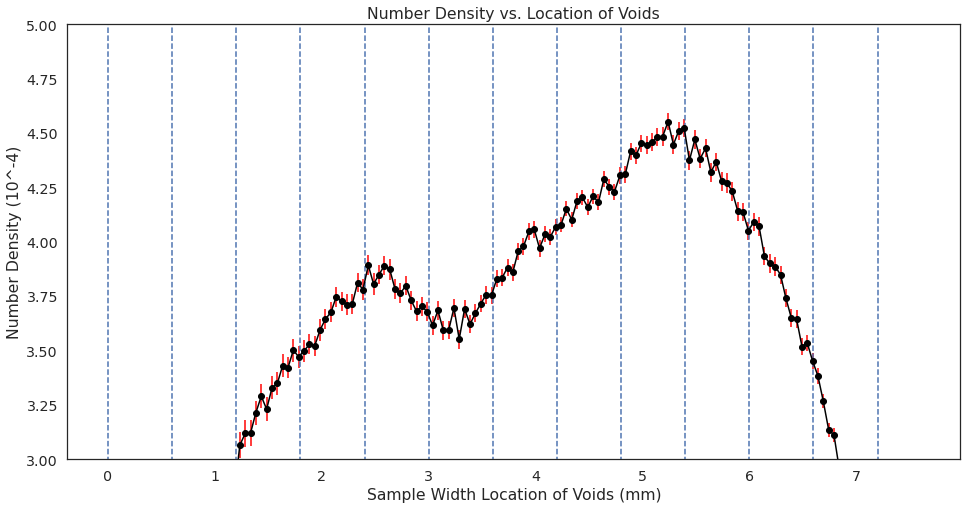

In [41]:
sns.set(font_scale=1.3)
sns.set_style(style = "white")
fig, ax = plt.subplots(1,1, figsize = (16,8))
ax.errorbar(y_cent_mean, num_den_mean, xerr=y_cent_std, yerr=num_den_std, fmt='-o', color = 'black', ecolor = 'red')
ax.set_title("Number Density vs. Location of Voids")
ax.set_ylabel("Number Density (10^-4)")
ax.set_xlabel("Sample Width Location of Voids (mm)")
#ax.set(xlim=(20, 1130))

# lines
lines_2500um = np.arange(0,max(y_cent_mean),0.6)
ax.vlines(lines_2500um, 0, 6,linestyles='--')
ax.set_ylim([3,5])

## Count cracks by Z  

In [3]:
def count_cracks(voids, cutoff = 3.0):
    z_cents = voids["cents"][:,0]*3.13*4*10**(-3)
    slab_id = (z_cents//0.05).astype(np.uint64)
    norm_feret = np.array(voids["max_feret"]["norm_dia"])
    
    count = []
    for i in range(np.max(slab_id)):
        idxs = np.where(slab_id==i)
        count.append(np.sum(norm_feret[idxs] > cutoff))

    x_mm = np.arange(0,np.max(slab_id))*0.05+0.025
    return x_mm, np.asarray(count)

In [4]:
x_mm, crack_count = count_cracks(voids_all, cutoff = CUTOFF_CRACKS)

sns.set(font_scale=1.3)
sns.set_style(style = "white")
fig, ax = plt.subplots(1,1, figsize = (16,8))
ax.errorbar(x_mm, crack_count, xerr=0, yerr=0, fmt='-o', color = 'black', ecolor = 'red')
ax.set_title("Count Cracks vs. Location of Voids")
ax.set_ylabel("Crack Count")
ax.set_xlabel("Sample Width Location of Voids (mm)")
#ax.set(xlim=(20, 1130))

top = np.max(crack_count)+5
bot = np.min(crack_count)-5
lines_2500um = np.arange(0,max(x_mm),0.6)
ax.vlines(lines_2500um, bot, top,linestyles='--')
ax.set_ylim([bot,top])
# plt.show()
plt.savefig(plots_dir + f'crack_count_sample{sample_name}_cutoff{CUTOFF_CRACKS}.png', format = 'png')
plt.close()

NameError: name 'voids_all' is not defined

## Number Density by Z  (new)

In [5]:
CUTOFF_CRACKS = 4.0

def number_density_z(voids, axis = 0):
    z_cents = voids["cents"][:,axis]*3.13*4*10**(-3)
    slab_id = (z_cents//0.05).astype(np.uint64)
    num_den = np.array(voids_all["number_density"])/eq_sph_vol
    
    num_den_mean = []
    num_den_std = []
    for i in range(np.max(slab_id)):
        idxs = np.where(slab_id==i)
        num_den_mean.append(np.mean(num_den[idxs]))
        num_den_std.append(np.std(num_den[idxs])/np.sqrt(np.size(idxs)))
        

    x_mm = np.arange(0,np.max(slab_id))*0.05+0.025
    return x_mm, np.asarray(num_den_mean)*10**4, np.asarray(num_den_std)*10**4

(3.0, 5.0)

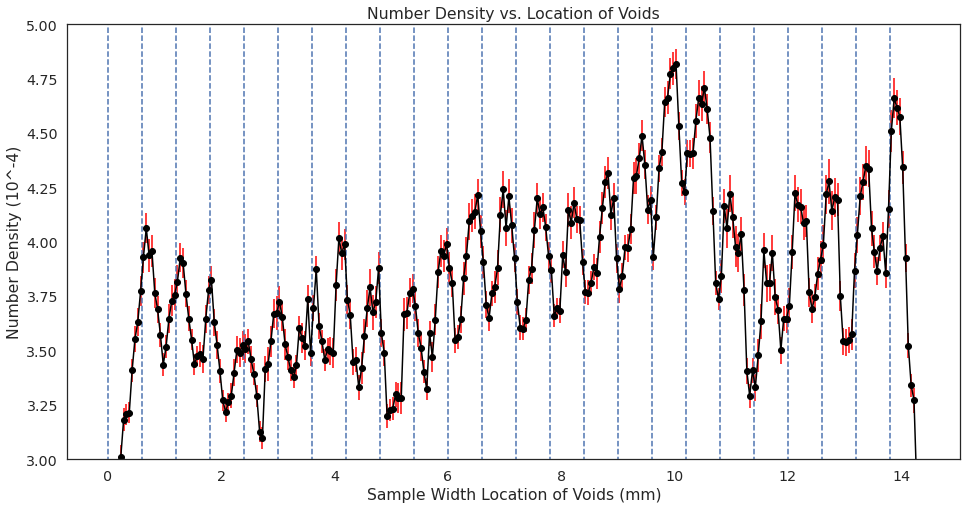

In [208]:
x_mm, num_den_mean, num_den_std = number_density_z(voids_all)

sns.set(font_scale=1.3)
sns.set_style(style = "white")
fig, ax = plt.subplots(1,1, figsize = (16,8))
ax.errorbar(x_mm, num_den_mean, xerr=0, yerr=num_den_std, fmt='-o', color = 'black', ecolor = 'red')
ax.set_title("Number Density vs. Location of Voids")
ax.set_ylabel("Number Density (10^-4)")
ax.set_xlabel("Sample Width Location of Voids (mm)")
#ax.set(xlim=(20, 1130))

top = np.max(num_den_mean)+0.5
bot = np.min(num_den_mean)-0.5
lines_2500um = np.arange(0,max(x_mm),0.6)
ax.vlines(lines_2500um, bot, top,linestyles='--')
ax.set_ylim([bot,top])
# plt.show()
plt.savefig(plots_dir + f'number_density_sample{sample_name}.png', format='png')
plt.close()

## Mean Size with z

In [6]:
def plot_mean_size_z_slabs(voids):
    z_cents = voids["cents"][:,0]*3.13*4*10**(-3)
    x_voids_vol = np.cbrt(voids["sizes"])
    slab_id = (z_cents//0.05).astype(np.uint64)
    
    mean_size_mean = []
    mean_size_std = []
    for i in range(np.max(slab_id)):
        idxs = np.where(slab_id==i)
        mean_size_mean.append(np.mean(x_voids_vol[idxs])) #to-do: convert to mm
        mean_size_std.append(np.std(x_voids_vol[idxs])/np.sqrt(np.size(idxs)))

    x_mm = np.arange(0,np.max(slab_id))*0.05+0.025
    return x_mm, np.asarray(mean_size_mean), np.asarray(mean_size_std) #*10**4

(3.2222249359381894, 5.579101347546646)

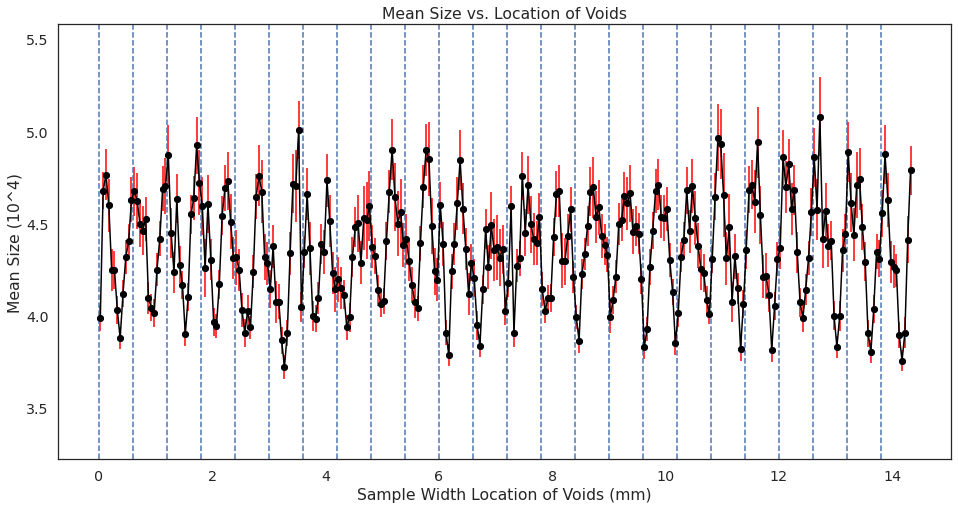

In [263]:
x_mm, mean_size, mean_size_std = plot_mean_size_z_slabs(voids_all)

sns.set(font_scale=1.3)
sns.set_style(style = "white")
fig, ax = plt.subplots(1,1, figsize = (16,8))
ax.scatter(x_mm, mean_size)
ax.errorbar(x_mm, mean_size, xerr=0, yerr=mean_size_std, fmt='-o', color = 'black', ecolor = 'red')
ax.set_title("Mean Size vs. Location of Voids")
ax.set_ylabel("Mean Size (10^4)")
ax.set_xlabel("Sample Width Location of Voids (mm)")
#ax.set(xlim=(0,8))

top = np.max(mean_size)+0.5
bot = np.min(mean_size)-0.5
lines_2500um = np.arange(0,max(x_mm),0.6)
ax.vlines(lines_2500um, bot, top,linestyles='--')
ax.set_ylim([bot,top])
# plt.show()
plt.savefig(plots_dir+f'mean_size_sample{sample_name}.png', format = 'png')
plt.close()


## Orientation of cracks

In [7]:
def crack_orientation(voids, cutoff = 3.0):
    z_cents = voids["cents"][:,0]*3.13*4*10**(-3)
    slab_id = (z_cents//0.05).astype(np.uint64)
    
    theta_mean = []
    theta_std = []
    phi_mean = []
    phi_std = []
    for i in range(np.max(slab_id)):
        idxs = np.where((slab_id==i) & (voids["max_feret"]["norm_dia"] > cutoff))
        theta_mean.append(np.mean(voids["max_feret"]["theta"][idxs]))
        theta_std.append(np.std(voids["max_feret"]["theta"][idxs])/np.sqrt(np.size(idxs)))
        phi_mean.append(np.mean(voids["max_feret"]["phi"][idxs]))
        phi_std.append(np.std(voids["max_feret"]["phi"][idxs])/np.sqrt(np.size(idxs)))

    x_mm = np.arange(0,np.max(slab_id))*0.05+0.025
    return x_mm, np.asarray(theta_mean), np.asarray(theta_std), np.asarray(phi_mean), np.asarray(phi_std)


In [ ]:
x_mm, theta_mean, theta_std, phi_mean, phi_std = crack_orientation(voids_all, cutoff = 3.0)

sns.set(font_scale=1.3)
sns.set_style(style = "white")
fig, ax = plt.subplots(1,1, figsize = (16,8))
ax.scatter(x_mm, theta_mean)
ax.errorbar(x_mm, theta_mean, xerr=0, yerr=theta_std, fmt='-o', color = 'black', ecolor = 'red')
ax.set_title("Mean Size vs. Location of Voids")
ax.set_ylabel("Mean Size (10^4)")
ax.set_xlabel("Sample Width Location of Voids (mm)")
#ax.set(xlim=(0,8))

top = np.max(theta_mean)+0.5
bot = np.min(theta_mean)-0.5
lines_2500um = np.arange(0,max(x_mm),0.6)
ax.vlines(lines_2500um, bot, top,linestyles='--')
ax.set_ylim([bot,top])
# plt.show()
plt.savefig(plots_dir+f'theta_orientation_sample{sample_name}.png', format = 'png')
plt.close()

sns.set(font_scale=1.3)
sns.set_style(style = "white")
fig, ax = plt.subplots(1,1, figsize = (16,8))
ax.scatter(x_mm, phi_mean)
ax.errorbar(x_mm, phi_mean, xerr=0, yerr=phi_std, fmt='-o', color = 'black', ecolor = 'red')
ax.set_title("Mean Size vs. Location of Voids")
ax.set_ylabel("Mean Size (10^4)")
ax.set_xlabel("Sample Width Location of Voids (mm)")
#ax.set(xlim=(0,8))

top = np.max(phi_mean)+0.5
bot = np.min(phi_mean)-0.5
lines_2500um = np.arange(0,max(x_mm),0.6)
ax.vlines(lines_2500um, bot, top,linestyles='--')
ax.set_ylim([bot,top])
# plt.show()
plt.savefig(plots_dir+f'phi_orientation_sample{sample_name}.png', format = 'png')
plt.close()

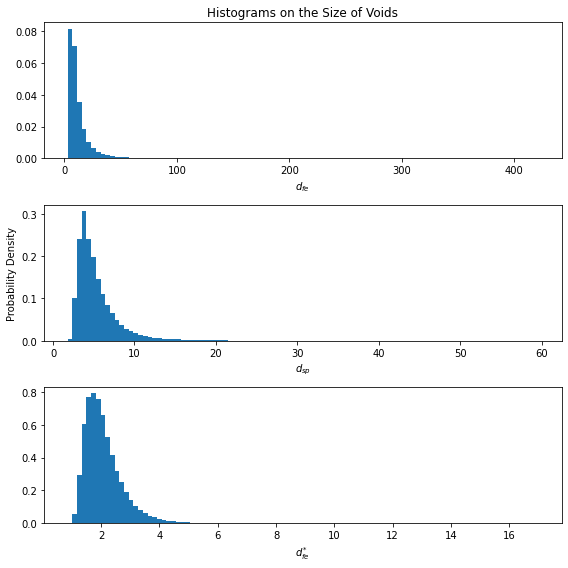

In [10]:
labels = ["$d_{fe}$", "$d_{sp}$", "$d^{*}_{fe}$", "$\Theta$", "$\phi$"]
fig, ax = plt.subplots(3,1, figsize = (8,8), sharex = False)
ax[0].hist(feret_dm, bins = 100, density = True)
ax[1].hist(eq_sph_dm, bins = 100, density = True)
ax[2].hist(norm_dm, bins = 100, density = True)
ax[0].set_title("Histograms on the Size of Voids")
ax[1].set_ylabel("Probability Density")
ax[0].set_xlabel(labels[0])
ax[1].set_xlabel(labels[1])
ax[2].set_xlabel(labels[2])
plt.tight_layout()
plt.show()

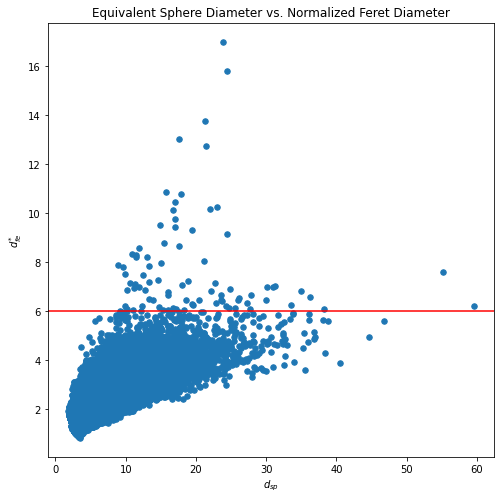

In [11]:
feret_thresh = 6
fig, ax = plt.subplots(1,1, figsize = (8,8))
ax.scatter(eq_sph_dm,norm_dm, s=30)
ax.set_xlabel(labels[1])
ax.set_ylabel(labels[2])
ax.set_title("Equivalent Sphere Diameter vs. Normalized Feret Diameter")
#plt.axvline(x = 15, color = "black")
plt.axhline(y = feret_thresh, color = "red")
plt.show()

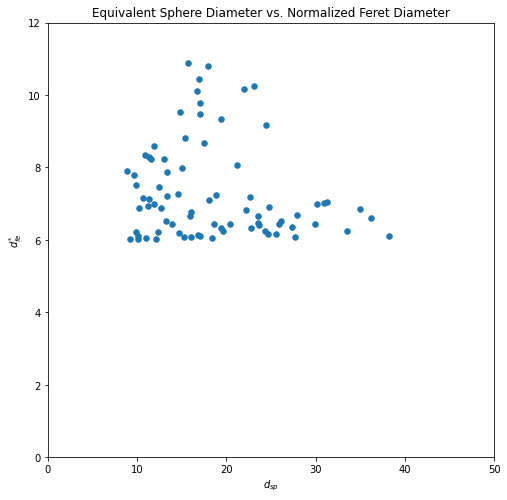

In [12]:
feret_dm_adj = [] 
eq_sph_dm_adj = []
norm_dm_adj = []
theta_adj = []
phi_adj = []
for i in range(len(norm_dm)):
    if norm_dm[i]>=feret_thresh:
        feret_dm_adj.append(feret_dm[i])
        eq_sph_dm_adj.append(eq_sph_dm[i])
        norm_dm_adj.append(norm_dm[i])
        theta_adj.append(theta[i])
        phi_adj.append(phi[i])

fig, ax = plt.subplots(1,1, figsize = (8,8))
ax.scatter(eq_sph_dm_adj,norm_dm_adj, s=30)
ax.set_title("Equivalent Sphere Diameter vs. Normalized Feret Diameter")
ax.set_xlabel(labels[1])
ax.set_ylabel(labels[2])
ax.set(xlim=(0, 50), ylim=(0, 12))
plt.show()


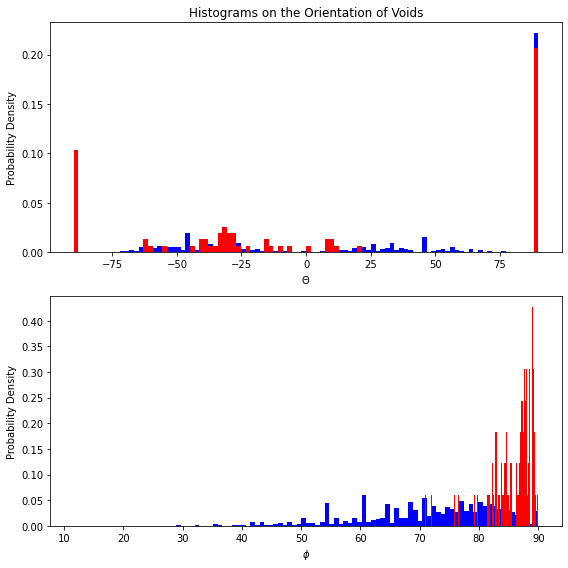

In [24]:
#Orientation
fig, ax = plt.subplots(2,1, figsize = (8,8))
ax[0].hist(theta, bins=100, color = 'blue', density = True)
ax[0].hist(theta_adj, bins=100, color = 'red', density = True)
ax[1].hist(phi, bins=100, color = 'blue', density = True)
ax[1].hist(phi_adj, bins=100, color = 'red', density = True)
ax[0].set_title("Histograms on the Orientation of Voids")
ax[0].set_xlabel(labels[3])
ax[1].set_xlabel(labels[4])
ax[0].set_ylabel("Probability Density")
ax[1].set_ylabel("Probability Density")
plt.tight_layout()
plt.show()

In [ ]:
#Crack count bar graph

sample_num = ['1','2','3','4','5','6','7','9','10','11','12']
fpath = f'/data01/Eaton_Polymer_AM/voids_data/sample{sample_num}_all_layers'

for i in range(len(sample_num)):    
    radius = 50
    voids_all = VoidLayers().import_from_disk(fpath)
    voids_all.keys()
    voids_all.calc_max_feret_dm()
    voids_all.calc_number_density(radius)
    
    feret_dm = voids_all["max_feret"]["dia"]
    eq_sph_dm = voids_all["max_feret"]["eq_sph"]
    norm_dm = voids_all["max_feret"]["norm_dia"]
    eq_sph_vol = (4/3)*np.pi*radius**3
    x_voids = voids_all["x_voids"]
    num_den = np.array(voids_all["number_density"])/eq_sph_vol

    fig, ax = plt.subplots(1,1, figsize = (8,8))
    ax.bar(sample_num[i], np.sum(crack_count))
    ax.set_title("Number of Cracks in each Sample")
    ax.set_xlabel("Sample Number")
    ax.set_ylabel("Number of Cracks")
    #plt.show()
    plt.savefig(plots_dir+f'barplot_crack_number_{sample_num}_{CUTOFF_CRACKS}.png', format = 'png')
    plt.close()

    fig, ax = plt.subplots(1,1, figsize = (8,8))
    ax.bar(sample_num[i], np.sum([np.cbrt(np.sum(i)) for i in x_voids]/len(x_voids)))
    ax.set_title("Average Void Size in each Sample")
    ax.set_xlabel("Sample Number")
    ax.set_ylabel("Average Voids Size")
    #plt.show()
    plt.savefig(plots_dir+f'barplot_mean_size_{sample_num}.png', format = 'png')
    plt.close()
    
    fig, ax = plt.subplots(1,1, figsize = (8,8))
    ax.bar(sample_num[i], np.sum([np.sum(i) for i in num_den]/len(x_voids)))
    ax.set_title("Average Number Density in each Sample")
    ax.set_xlabel("Sample Number")
    ax.set_ylabel("Average Voids Size")
    #plt.show()
    plt.savefig(plots_dir+f'barplot_mean_number_density_{sample_num}.png', format = 'png')
    plt.close()
    

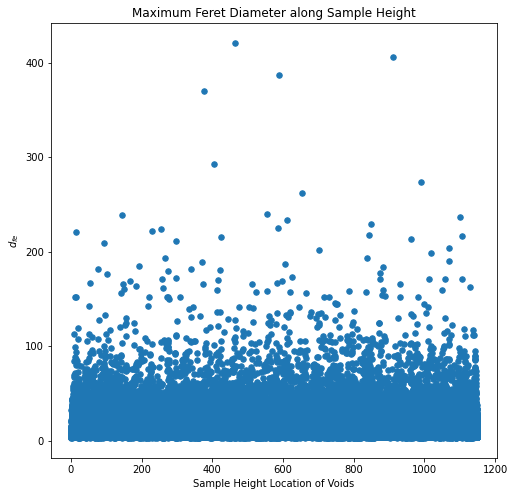

In [25]:
#Size Distribution
fig, ax = plt.subplots(1,1, figsize = (8,8))
ax.scatter(voids_all['cents'][:,0],feret_dm, s=30)
ax.set_title("Maximum Feret Diameter along Sample Height")
ax.set_xlabel("Sample Height Location of Voids")
ax.set_ylabel(labels[0])
#ax.set(xlim=(0, 50), ylim=(0, 12))
plt.show()

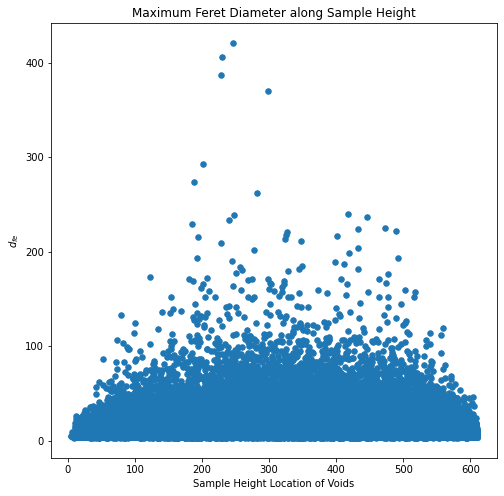

In [26]:
#Size Distribution
fig, ax = plt.subplots(1,1, figsize = (8,8))
ax.scatter(voids_all['cents'][:,1],feret_dm, s=30)
ax.set_title("Maximum Feret Diameter along Sample Height")
ax.set_xlabel("Sample Height Location of Voids")
ax.set_ylabel(labels[0])
#ax.set(xlim=(0, 50), ylim=(0, 12))
plt.show()

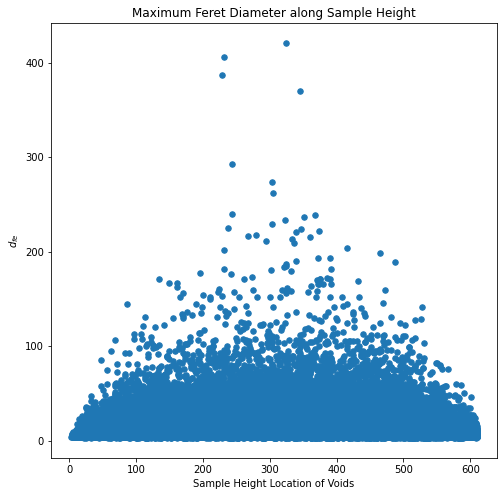

In [29]:
#Size Distribution
fig, ax = plt.subplots(1,1, figsize = (8,8))
ax.scatter(voids_all['cents'][:,2],feret_dm, s=30)
ax.set_title("Maximum Feret Diameter along Sample Height")
ax.set_xlabel("Sample Height Location of Voids")
ax.set_ylabel(labels[0])
#ax.set(xlim=(0, 50), ylim=(0, 12))
plt.show()

In [32]:
df = pd.read_csv(save_path)
sample_tag = df["sample_num"]
layer = df['layer']

porosity = []
for i in range(len(sample_tag)):
    for j in range(len(layer)):
        projs, theta, center, dark, flat = read_raw_data_1X(str(sample_tag[i]), str(layer[j]))
        voids = void_map_gpu(projs, theta, center, dark, flat, b, pixel_size)
        count = np.sum([np.sum(k) for k in voids['x_voids']])
        vol = 288*612*612*(np.pi/4)
        porosity.append(count/vol)
        

NameError: name 'void_map_gpu' is not defined

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (8,8))
ax.bar(sample_tag, porosity)
ax.set_title("Porosity Values of Each Sample")
ax.set_xlabel("Sample Number")
ax.set_ylabel("Porosity")
plt.show()